In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split
from PIL import Image

import torch.nn.functional as F
from torchvision.models import resnet18
from torch.utils.data import DataLoader,random_split
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
path= "/content/drive/MyDrive/Cat_Dog_Images/Images"

In [ ]:
# metadata.to_csv("/content/drive/MyDrive/Cat_Dog_Images/metadata_ok.csv", index= False)

In [ ]:
metadata= "/content/drive/MyDrive/Cat_Dog_Images/metadata_ok.csv"

In [ ]:
# pd.read_csv(metadata, header= 1)

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, metadata, dir_root,transform= None):
        self.dir_root= dir_root
        self.annotations= pd.read_csv(metadata, header= 1)
        self.transform= transform
        
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        
        fileName= self.annotations.iloc[idx, 0]
        im= os.path.join(self.dir_root, fileName)
        img = Image.open(im).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        classCategory= self.annotations.iloc[idx, 1]
        # group= self.annotations.iloc[idx, 2]
        # im_group= self.group_array[idx]
        # split= self.annotations.iloc[idx, 3] # 0: train, 1: valid, 2: test
        return img, im, classCategory

In [ ]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.RandomResizedCrop(224),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


In [ ]:
data= CustomDataSet(metadata, path, transform= transform)

In [ ]:
data

In [ ]:
len(data)

16

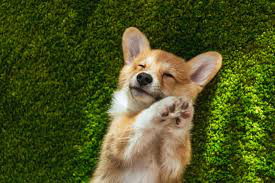

In [ ]:
Image.open(data[10][1])

In [ ]:
def img_display(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [ ]:
batch_size= 16
train_size= 0.8
train_size= int(train_size*len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
data[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# for i, _, j in train_loader:
#   print(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


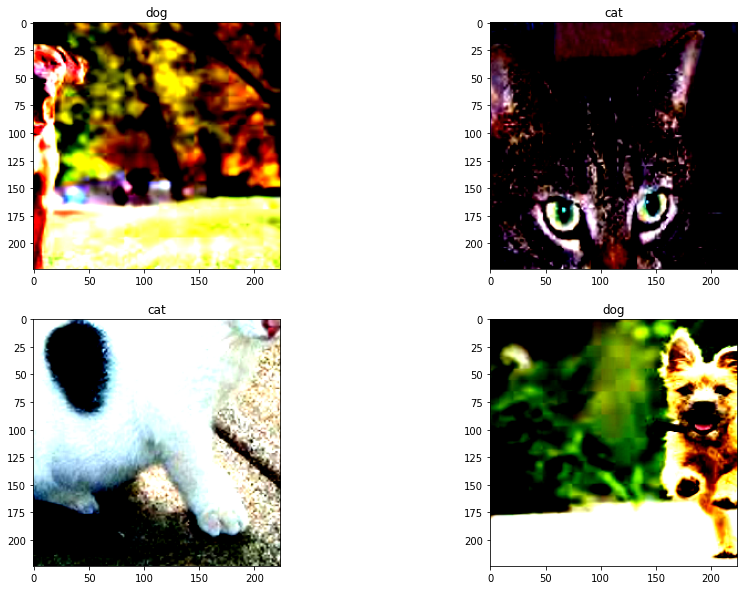

In [ ]:
dataiter = iter(train_loader)
images, img, labels= dataiter.next()
bird_type = {0: 'cat', 1: 'dog'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label= images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        
        ax.set(title = f"{bird_type[label.item()]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


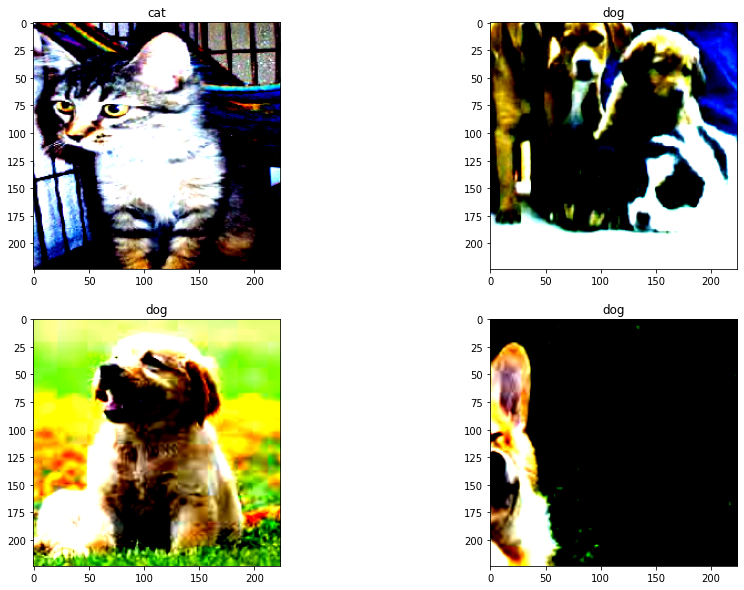

In [ ]:
dataiter = iter(val_loader)
images, img, labels= dataiter.next()
bird_type = {0: 'cat', 1: 'dog'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label= images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        
        ax.set(title = f"{bird_type[label.item()]}")

In [ ]:
# train_loader

In [ ]:
model= torchvision.models.resnet50(pretrained= True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

# model.to(device)

In [ ]:
criterion= nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, weight_decay=1.0)
num_epochs= 30

In [ ]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 

    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    val_loss_min = np.Inf
    total_step = len(train_loader)
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    
    # Loop over epochs.
    # for epoch in range(num_epochs):
    for epoch in tqdm(range(num_epochs)):
      running_loss = 0.0
      correct = 0
      total = 0
        
      # Loop over data.
      for data, _, target in data_loader:
            
          # Forward pass.
          output =model(data.to(device))
          loss = criterion(output.to(device).squeeze(), target.to(device).float())
          # loss.requires_grad = True
          # print(loss)
          # Backward pass.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss +=loss.item()
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.cpu().eq(target.view_as(pred)).sum().item()
          total += target.size(0)
          
      print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, running_loss/total_step),
      )
      
      train_acc.append(100 * correct/total)
      train_loss.append(running_loss/total_step)



      # Validation
      batch_loss = 0
      total_t = 0
      correct_t = 0
      with torch.no_grad():
          model.eval()
          for data_t,_, target_t in val_loader:
              data_t,target_t = data_t.to(device),target_t.to(device)
              outputs_t = model(data_t)
              loss_t = criterion(outputs_t.squeeze(),target_t.float())
              batch_loss+=loss.item()
              _,pred_t = torch.max(outputs_t,dim=1)
              correct_t += torch.sum(pred_t==target_t).item()
              total_t += target_t.size(0)
          val_acc.append(100 * correct_t/total_t)
          val_loss.append(batch_loss/len(val_loader))
          network_achieve = batch_loss < val_loss_min
        

          if network_achieve:
              val_loss_min = batch_loss
              torch.save(model.state_dict(), '/content/model_ok.ckpt')

              print('The best model is detected')


    # torch.save(model.state_dict(), 'model.pth')
    percent = 100. * correct / len(data_loader.dataset)
    return model, percent, val_loss, val_acc, train_loss, train_acc

In [ ]:
model_trained, percent, val_loss, val_acc, train_loss, train_acc= train(model, criterion, train_loader, optimizer, num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 	Loss: 0.368720


  3%|▎         | 1/30 [00:03<01:47,  3.71s/it]

The best model is detected
Train Epoch: 1 	Loss: 0.344897


  7%|▋         | 2/30 [00:07<01:37,  3.47s/it]

The best model is detected
Train Epoch: 2 	Loss: 0.269618


 10%|█         | 3/30 [00:10<01:30,  3.35s/it]

The best model is detected
Train Epoch: 3 	Loss: 0.277327


 13%|█▎        | 4/30 [00:13<01:21,  3.15s/it]

Train Epoch: 4 	Loss: 0.238514


 17%|█▋        | 5/30 [00:16<01:19,  3.17s/it]

The best model is detected
Train Epoch: 5 	Loss: 0.249739


 20%|██        | 6/30 [00:19<01:14,  3.12s/it]

Train Epoch: 6 	Loss: 0.234249


 23%|██▎       | 7/30 [00:22<01:13,  3.18s/it]

The best model is detected
Train Epoch: 7 	Loss: 0.251922


 27%|██▋       | 8/30 [00:25<01:08,  3.09s/it]

Train Epoch: 8 	Loss: 0.237161


 30%|███       | 9/30 [00:28<01:04,  3.05s/it]

Train Epoch: 9 	Loss: 0.251560


 33%|███▎      | 10/30 [00:31<00:59,  2.98s/it]

Train Epoch: 10 	Loss: 0.189679


 37%|███▋      | 11/30 [00:34<00:58,  3.07s/it]

The best model is detected
Train Epoch: 11 	Loss: 0.216688


 40%|████      | 12/30 [00:37<00:54,  3.01s/it]

Train Epoch: 12 	Loss: 0.219277


 43%|████▎     | 13/30 [00:40<00:50,  2.98s/it]

Train Epoch: 13 	Loss: 0.219869


 47%|████▋     | 14/30 [00:43<00:47,  2.94s/it]

Train Epoch: 14 	Loss: 0.208323


 50%|█████     | 15/30 [00:46<00:43,  2.92s/it]

Train Epoch: 15 	Loss: 0.191145


 53%|█████▎    | 16/30 [00:49<00:41,  2.93s/it]

Train Epoch: 16 	Loss: 0.198966


 57%|█████▋    | 17/30 [00:51<00:37,  2.91s/it]

Train Epoch: 17 	Loss: 0.200076


 60%|██████    | 18/30 [00:54<00:34,  2.88s/it]

Train Epoch: 18 	Loss: 0.201797


 63%|██████▎   | 19/30 [00:57<00:31,  2.90s/it]

Train Epoch: 19 	Loss: 0.172141


 67%|██████▋   | 20/30 [01:00<00:29,  3.00s/it]

The best model is detected
Train Epoch: 20 	Loss: 0.158635


 70%|███████   | 21/30 [01:04<00:27,  3.10s/it]

The best model is detected
Train Epoch: 21 	Loss: 0.165055


 73%|███████▎  | 22/30 [01:07<00:25,  3.20s/it]

Train Epoch: 22 	Loss: 0.137945


 77%|███████▋  | 23/30 [01:10<00:22,  3.20s/it]

The best model is detected
Train Epoch: 23 	Loss: 0.226242


 80%|████████  | 24/30 [01:13<00:18,  3.11s/it]

Train Epoch: 24 	Loss: 0.160349


 83%|████████▎ | 25/30 [01:16<00:15,  3.07s/it]

Train Epoch: 25 	Loss: 0.219331


 87%|████████▋ | 26/30 [01:19<00:12,  3.02s/it]

Train Epoch: 26 	Loss: 0.229240


 90%|█████████ | 27/30 [01:22<00:09,  3.03s/it]

Train Epoch: 27 	Loss: 0.126321


 93%|█████████▎| 28/30 [01:25<00:06,  3.07s/it]

The best model is detected
Train Epoch: 28 	Loss: 0.128631


 97%|█████████▋| 29/30 [01:28<00:03,  3.01s/it]

Train Epoch: 29 	Loss: 0.147897


100%|██████████| 30/30 [01:31<00:00,  3.06s/it]


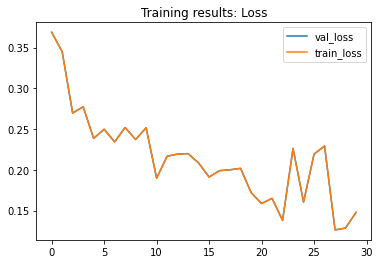

In [ ]:
plt.title("Training results: Loss")
plt.plot(val_loss,label='val_loss')
plt.plot(train_loss, label="train_loss")
plt.legend()

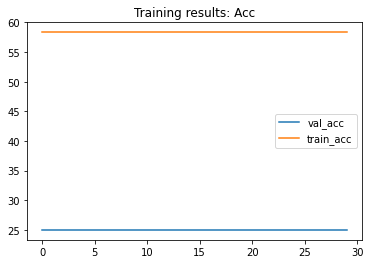

In [ ]:
plt.title("Training results: Acc")
plt.plot(val_acc,label='val_acc')
plt.plot(train_acc, label="train_acc")
plt.legend()

In [ ]:
val_acc

[25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0]

In [ ]:
train_acc

[58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336,
 58.333333333333336]

In [ ]:
# CNN Model (2 conv layers)
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(9408, 1, bias=True)
        self.m = nn.Sigmoid()
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  
        # print(out.shape) 
        out = self.fc(out)
        out= self.m(out)
        return out

# instantiate CNN model
model = CNN().to(device)

In [ ]:
model_trained, percent, val_loss, val_acc, train_loss, train_acc= train(model, criterion, train_loader, optimizer, num_epochs)

  3%|▎         | 1/30 [00:00<00:06,  4.52it/s]

Train Epoch: 0 	Loss: 0.681731
The best model is detected
Train Epoch: 1 	Loss: 0.683122


 13%|█▎        | 4/30 [00:00<00:04,  5.59it/s]

Train Epoch: 2 	Loss: 0.671309
The best model is detected
Train Epoch: 3 	Loss: 0.716200


 17%|█▋        | 5/30 [00:00<00:04,  5.54it/s]

Train Epoch: 4 	Loss: 0.690394
Train Epoch: 5 	Loss: 0.695101


 23%|██▎       | 7/30 [00:01<00:03,  5.79it/s]

Train Epoch: 6 	Loss: 0.683704
Train Epoch: 7 	Loss: 0.676594


 30%|███       | 9/30 [00:01<00:03,  5.59it/s]

Train Epoch: 8 	Loss: 0.688353
Train Epoch: 9 	Loss: 0.681662


 37%|███▋      | 11/30 [00:02<00:03,  5.35it/s]

Train Epoch: 10 	Loss: 0.699586
Train Epoch: 11 	Loss: 0.691363


 43%|████▎     | 13/30 [00:02<00:03,  5.18it/s]

Train Epoch: 12 	Loss: 0.681319
Train Epoch: 13 	Loss: 0.692220

 47%|████▋     | 14/30 [00:02<00:03,  5.08it/s]


Train Epoch: 14 	Loss: 0.689397


 53%|█████▎    | 16/30 [00:03<00:02,  5.06it/s]

Train Epoch: 15 	Loss: 0.702121
Train Epoch: 16 	Loss: 0.682347


 60%|██████    | 18/30 [00:03<00:02,  5.24it/s]

Train Epoch: 17 	Loss: 0.678727
Train Epoch: 18 	Loss: 0.697789


 67%|██████▋   | 20/30 [00:03<00:01,  5.44it/s]

Train Epoch: 19 	Loss: 0.690949
Train Epoch: 20 	Loss: 0.683634


 73%|███████▎  | 22/30 [00:04<00:01,  5.59it/s]

Train Epoch: 21 	Loss: 0.684730
Train Epoch: 22 	Loss: 0.679182


 80%|████████  | 24/30 [00:04<00:01,  5.68it/s]

Train Epoch: 23 	Loss: 0.676245
Train Epoch: 24 	Loss: 0.707650


 87%|████████▋ | 26/30 [00:04<00:00,  5.72it/s]

Train Epoch: 25 	Loss: 0.686368
Train Epoch: 26 	Loss: 0.704483


 93%|█████████▎| 28/30 [00:05<00:00,  5.74it/s]

Train Epoch: 27 	Loss: 0.686321
Train Epoch: 28 	Loss: 0.689498


100%|██████████| 30/30 [00:05<00:00,  5.46it/s]

Train Epoch: 29 	Loss: 0.696579


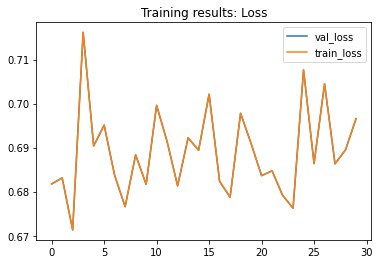

In [ ]:
plt.title("Training results: Loss")
plt.plot(val_loss,label='val_loss')
plt.plot(train_loss, label="train_loss")
plt.legend()

In [ ]:
#plt.title("Training results: Loss")
plt.plot(val_loss,label='val_loss')
plt.plot(train_loss, label="train_loss")
plt.legend()

In [ ]:
## Add a function form predict in local (predict.py)

In [ ]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    loss_ep= []
    
    # Loop over epochs.
    for epoch in tqdm(range(num_epochs)):
      loss_bct= 0.0
        
      # Loop over data.
      for data, _, target in data_loader:
            
          # Forward pass.
          output = model(data.to(device))
          loss = criterion(output.to(device).squeeze(), target.to(device).float())
          
          # Backward pass.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          loss_bct+= loss.item()
          
          # NOTE: It is important to call .item() on the loss before summing.
          if ema_loss is None:
            ema_loss = loss.item()
          else:
            ema_loss += (loss.item() - ema_loss) * 0.01 
          
      # Print out progress the end of epoch.
      print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, ema_loss),
      )
      loss_ep.append(loss_bct)

    return model, loss_ep

In [ ]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    loss_ep= []

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        
        # Loop over test data.
        for data, _, target in data_loader:
          
            # Forward pass.
            output = model(data.to(device))
            loss = criterion(output.to(device).squeeze(), target.to(device).float())
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            l+=loss.item()
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()
        loss_ep.append(l)

    # Print test accuracy.
    percent = 100. * correct / len(data_loader.dataset)
    print(f'Accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)')
    return percent,loss_ep

In [ ]:
model_train, train_loss= train(model, criterion, train_loader, optimizer, num_epochs=10)

 10%|█         | 1/10 [00:07<01:11,  7.96s/it]

Train Epoch: 0 	Loss: 0.872530


 20%|██        | 2/10 [00:15<01:02,  7.86s/it]

Train Epoch: 1 	Loss: 0.869698


 30%|███       | 3/10 [00:23<00:55,  7.90s/it]

Train Epoch: 2 	Loss: 0.867381


 40%|████      | 4/10 [00:31<00:47,  7.90s/it]

Train Epoch: 3 	Loss: 0.858624


 50%|█████     | 5/10 [00:39<00:39,  7.84s/it]

Train Epoch: 4 	Loss: 0.855337


 60%|██████    | 6/10 [00:47<00:31,  7.84s/it]

Train Epoch: 5 	Loss: 0.849019


 70%|███████   | 7/10 [00:55<00:23,  7.91s/it]

Train Epoch: 6 	Loss: 0.837395


 80%|████████  | 8/10 [01:03<00:15,  7.90s/it]

Train Epoch: 7 	Loss: 0.824300


 90%|█████████ | 9/10 [01:11<00:07,  7.94s/it]

Train Epoch: 8 	Loss: 0.822511


100%|██████████| 10/10 [01:19<00:00,  7.91s/it]

Train Epoch: 9 	Loss: 0.819891


In [ ]:
_, val_loss= test(model_train, val_loader)

Accuracy: 2 / 4 (50%)


In [ ]:
val_loss

[0.897377610206604]

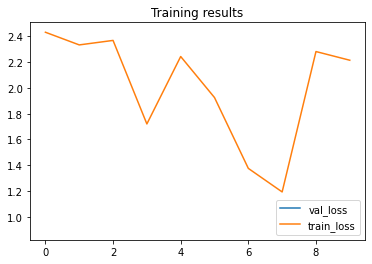

In [ ]:
plt.title("Training results")
plt.plot(val_loss,label='val_loss')
plt.plot(train_loss, label="train_loss")
plt.legend()

In [ ]:
# Prediction
def image_transform(imagepath):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    image = Image.open(imagepath)
    imagetensor = test_transforms(image)
    return imagetensor


def predict(imagepath, verbose=False):
    if not verbose:
        warnings.filterwarnings('ignore')
    model_path = './model/model_ok.pth'
    try:
        checks_if_model_is_loaded = type(model)
    except:
        model = models.resnet50()
    model.eval()
    #summary(model, input_size=(3,244,244))
    if verbose:
        print("Model Loaded..")
    image = image_transform(imagepath)
    image1 = image[None,:,:,:]
    # ps= torch.exp(model(image1))
    ps= model(image1)
    topconf, topclass = ps.topk(1, dim=1)
    # print(ps)
    if topclass.item() == 1:
        return {'class':'dog','confidence':str(topconf.item())}
    else:
        return {'class':'cat','confidence':str(topconf.item())}



image_path= "Image_path"
# print(predict('data/Images/image_name'))
print(Image.open(image_path))
print(predict(image_path))